# Neural Style Transfer
<p class="summary">Implementation of "Image Style Transfer Using Convolutional Neural Networks." </p>

## Introduction
In this tutorial, we will implement the neural style transfer algorithm based on "Image Style Transfer Using Convolutional Neural Networks," Gatys et al. 2016.[1] (the preprint version was published in 2015[2].).

By using this algorithm, we can transfer the style from one image onto another as shown in the examples below (The figure from Gatys et al.[1]. A: The original content image, B-F: The generated images. The painting that provided the style for the respective generated image is shown in the bottom left corner of each panel.).

![](./fig/gatys2016_examples.png)

## Methods
In this section, we introduce the methods of the algorithm briefly.  
The figure below shows a schematic diagram of the algorithm[1].  

![](./fig/gatys2016_algorithm.png)

### Overview
The key idea of the algorithm is separation of image content from style. Using the content and style representations of images, we can measure the content and style similarity (loss) between images separately. Therefore, this problem can be solved as an optimization problem to minimize content and style loss. Gatys et al. performed gradient descent algorithm on a white noise image to find another image that matches content/style representations of input content/style images respectively.  
Let $\vec{p}$ and $\vec{a}$ be the input content and style image, and $\vec{x}$ be the image that is generated, then, this optimization problem is represented by the following equation

\begin{equation*}
 \vec{x}^{*}=\mathop{\rm argmin}\limits_{\vec{x}}(\alpha\mathcal{L}_{content}(\vec{p},\vec{x})+\beta\mathcal{L}_{style}(\vec{a},\vec{x})).
\end{equation*}

Then, how can we extract content and style representations separetely? Gatys et al. focused on the feature space provided by Convolutional Neural Networks.   

### Content representation
In general, when CNNs are trained on object recognition, higer layers in the network capture the high-level content of images. Thus, Gatys et al. refer to the feature responses in higher layers of the network as the content representation.   
Layer $l$ in the network has $N_l$ distinct filters (feature maps) each of size (the height times the width of the feature map) $M_l$. Let $\vec{p}$ and $\vec{x}$ be the original content image and the image that is generated, and $P^l$ and $F^l$ their respective feature representation in layer $l$. We then define the squared-error loss between the two feature representations

\begin{equation*}
 \mathcal{L}_{content} (\vec{p},\vec{x},l)=\frac{1}{2} \sum_{i,j}(F^l_{ij}-P^l_{ij})^2.
\end{equation*}

$F^l_{ij}\in \mathcal{R}^{N_l\times M_l}$ is the activation of the $i^{th}$filter at position $j$ in layer $l$. 

### Style representation
On the other hand, the style of the image is represented by the correlations between the different filter responses in any layer of the network. These feature correlations are given by the Gram matrix $G^l\in \mathcal{R}^{N_l \times N_l}$, where $G^l_{ij}$ is the inner product between the vectrized feature maps $i$ and $j$ in layer $l$:

\begin{equation*}
 G^l_{ij}=\sum_k F^l_{ik}F^l_{jk}.
\end{equation*}

Let $\vec{a}$ and $\vec{x}$ be the original style image and the image that is generated, and $A^l$ and $G^l$ their respective style representation in layer $l$. The contribution of layer $l$ to the total loss is then 

\begin{equation*}
 E_l=\frac{1}{4N_l^2 M_l^2} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2
\end{equation*}

and the total style loss is 

\begin{equation*}
 \mathcal{L}_{style}(\vec{a},\vec{x})=\sum_{l=0}^L w_l E_l,
\end{equation*}

where $w_l$ are weighting factors of each layer.

### Total loss & Optimization
Finally, the total loss function we minimize is

\begin{equation*}
 \mathcal{L}_{total}(\vec{p},\vec{a},\vec{x})=\alpha\mathcal{L}_{content}(\vec{p},\vec{x})+\beta\mathcal{L}_{style}(\vec{a},\vec{x}).
\end{equation*}

In the optimization step, the pixel values of $\vec{x}$ are updated to minimize the total loss function. The gradient with respect to the pixel values $\frac{\partial \mathcal{L}_{total}}{\partial \vec{x}}$ is computed using standard error back-propagation. Thus, gradient descent algorithm such as L-BFGS, Adam, and SGD can be applied.

Optionally, the total variation loss is added to the loss. This loss works as regularizer for smoothing the generated image.

## Required Libaries

- ReNom 2.6.2
- matplotlib 2.0.2
- numpy 1.12.1
- pillow 4.2.1

Now, let's implement the algorithm with ReNom.  
First, following libraries are required.  
If GPU is available on your environment, it is preferable to use it.

In [1]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
from __future__ import division, print_function
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
# If you would like to use GPU, set True, otherwise you should be set to False.
set_cuda_active(True)

np.random.seed(10)

## Settings
Some settings are required for executing the algorithm.

### Input/Output settings

In [2]:
# Input image path.
img_path_content = "./img/content/wolf.jpg"
img_path_style = "./img/style/starry_night.jpg"

# Output path and suffix.
img_path_results = "./img/results/results00/" # The generated images are saved here.
suffix_results = "result" # {suffix_results}_{iter}.jpg
try:
    os.mkdir(img_path_results)
except OSError:
    pass

# Size of images input to VGG model.
input_width = 400
input_size = (input_width, input_width)

### Loss function settings

In [3]:
# Model used to extract the feature maps. ("VGG16" or "VGG19")
modelname = "VGG16"
# modelname = "VGG19"

# Layers used to calculate the style loss and their weights.
layers_style = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
w_style = [1./len(layers_style)] * len(layers_style) # equal

# Layers used to calculate the content loss and their weights.
layers_content = ['conv5_2',] # In Gatys's paper, 'conv4_2' is recommended.
w_content = rm.Node(np.array([2**i for i in range(len(layers_content))]))
w_content = w_content / rm.sum(w_content) # bigger weight in higher layer

# Ratio of content loss to style loss (alpha/beta)
lam = 1e-4

# Ratio of total variation loss to style loss
eta = 1e-6

### Optimization settings

In [4]:
epoch = 2000
optimizer = Adam(lr=5.0)

# Initialization method of the generated image. (content image/random image)
init_mode = "content"
# init_mode = "rand"

## Define VGG network model
As mentioned above, we use the CNN network model to extract content and style representation. Here, we use the VGG network model[3] same as Gatys et al., but other models for object recognition such as NIN[4] and GoogLeNet[5] can be selected. The figure below shows the network structure of VGG-16.

![](./fig/vgg16.png)

If you run this tutorial for the first time, you need to prepare the pre-trained weights of the VGG model. The weights are open to the public as Caffe model [here](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and the method for converting them to ReNom models is provided in the tutorial "Using Pre-trained Caffe model in ReNom".  

Since we need only convolution layers of the VGG model, we load the model without top fully connected (dense) layers. Gatys et al. says replacing the maximum pooling operation by average pooling yields slightly better results, which is why average pooling is used.(Click [here](http://renom.jp/docs/downloads/weights/vgg.zip) to download weights.)

In [5]:
class VGG16_without_top(rm.Model):
    
    def __init__(self):
        super(VGG16_without_top, self).__init__()
        self.conv1_1 = rm.Conv2d(channel=64, padding=1, filter=3)
        self.conv1_2 = rm.Conv2d(channel=64, padding=1, filter=3)
        self.conv2_1 = rm.Conv2d(channel=128, padding=1, filter=3)
        self.conv2_2 = rm.Conv2d(channel=128, padding=1, filter=3)
        self.conv3_1 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv3_2 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv3_3 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv4_1 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv4_2 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv4_3 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_1 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_2 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_3 = rm.Conv2d(channel=512, padding=1, filter=3)
        self._pool = rm.AveragePool2d(filter=2, stride=2)
        # self._pool = rm.MaxPool2d(filter=2, stride=2)

    def forward(self, x):
        c1_1 = rm.relu(self.conv1_1(x))
        c1_2 = rm.relu(self.conv1_2(c1_1))
        p1 = self._pool(c1_2)

        c2_1 = rm.relu(self.conv2_1(p1))
        c2_2 = rm.relu(self.conv2_2(c2_1))
        p2 = self._pool(c2_2)
        
        c3_1 = rm.relu(self.conv3_1(p2))
        c3_2 = rm.relu(self.conv3_2(c3_1))
        c3_3 = rm.relu(self.conv3_3(c3_2))
        p3 = self._pool(c3_3)
        
        c4_1 = rm.relu(self.conv4_1(p3))
        c4_2 = rm.relu(self.conv4_2(c4_1))
        c4_3 = rm.relu(self.conv4_3(c4_2))
        p4 = self._pool(c4_3)
        
        c5_1 = rm.relu(self.conv5_1(p4))
        c5_2 = rm.relu(self.conv5_2(c5_1))
        c5_3 = rm.relu(self.conv5_3(c5_2))
        #p5 = self._pool(c5_3)

        k = ['conv1_1','conv1_2','conv2_1','conv2_2',
             'conv3_1','conv3_2','conv3_3',
             'conv4_1','conv4_2','conv4_3',
             'conv5_1','conv5_2','conv5_3',
             ]
        v = [c1_1, c1_2, c2_1, c2_2,
             c3_1, c3_2, c3_3,
             c4_1, c4_2, c4_3,
             c5_1, c5_2, c5_3,
             ]

        return dict(zip(k,v))

In [6]:
class VGG19_without_top(rm.Model):
    
    def __init__(self):
        super(VGG19_without_top, self).__init__()
        self.conv1_1 = rm.Conv2d(channel=64, padding=1, filter=3)
        self.conv1_2 = rm.Conv2d(channel=64, padding=1, filter=3)
        self.conv2_1 = rm.Conv2d(channel=128, padding=1, filter=3)
        self.conv2_2 = rm.Conv2d(channel=128, padding=1, filter=3)
        self.conv3_1 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv3_2 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv3_3 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv3_4 = rm.Conv2d(channel=256, padding=1, filter=3)
        self.conv4_1 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv4_2 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv4_3 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv4_4 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_1 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_2 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_3 = rm.Conv2d(channel=512, padding=1, filter=3)
        self.conv5_4 = rm.Conv2d(channel=512, padding=1, filter=3)
        self._pool = rm.AveragePool2d(filter=2, stride=2)
        # self._pool = rm.MaxPool2d(filter=2, stride=2)

    def forward(self, x):
        c1_1 = rm.relu(self.conv1_1(x))
        c1_2 = rm.relu(self.conv1_2(c1_1))
        p1 = self._pool(c1_2)

        c2_1 = rm.relu(self.conv2_1(p1))
        c2_2 = rm.relu(self.conv2_2(c2_1))
        p2 = self._pool(c2_2)
        
        c3_1 = rm.relu(self.conv3_1(p2))
        c3_2 = rm.relu(self.conv3_2(c3_1))
        c3_3 = rm.relu(self.conv3_3(c3_2))
        c3_4 = rm.relu(self.conv3_4(c3_3))
        p3 = self._pool(c3_4)
        
        c4_1 = rm.relu(self.conv4_1(p3))
        c4_2 = rm.relu(self.conv4_2(c4_1))
        c4_3 = rm.relu(self.conv4_3(c4_2))
        c4_4 = rm.relu(self.conv4_4(c4_3))
        p4 = self._pool(c4_4)
        
        c5_1 = rm.relu(self.conv5_1(p4))
        c5_2 = rm.relu(self.conv5_2(c5_1))
        c5_3 = rm.relu(self.conv5_3(c5_2))
        c5_4 = rm.relu(self.conv5_4(c5_3))
        #p5 = self._pool(c5_4)

        k = ['conv1_1','conv1_2','conv2_1','conv2_2',
             'conv3_1','conv3_2','conv3_3','conv3_4',
             'conv4_1','conv4_2','conv4_3','conv4_4',
             'conv5_1','conv5_2','conv5_3','conv5_4',
             ]
        v = [c1_1, c1_2, c2_1, c2_2,
             c3_1, c3_2, c3_3, c3_4,
             c4_1, c4_2, c4_3, c4_4,
             c5_1, c5_2, c5_3, c5_4,
             ]

        return dict(zip(k,v))

In [7]:
# Instantiate VGG model.
assert modelname in ["VGG16", "VGG19"], "modelname must be 'VGG16' or 'VGG19'"
if modelname == "VGG16":
    model = VGG16_without_top()
    model.load("./vgg/weights_vgg16_without_top.h5")
elif modelname == "VGG19":
    model = VGG19_without_top()
    model.load("./vgg/weights_vgg19_without_top.h5")

model.set_models(inference=True)
model.set_prevent_update(True) # Parameters of VGG are NOT updated.

## Define some utility functions
We need to preprocess input images to use the pre-trained VGG model.

In [8]:
mean = np.array([103.939, 116.779, 123.68]) # Mean pixel of ImageNet dataset.

def preprocess_img_vgg(img, size=(400, 400)):
    # PIL image -> numpy array for VGG model
    img = img.resize(size)
    x = np.asarray(img, dtype='float32')
    x = x[:,:,::-1] # RGB -> BGR
    x -= mean
    x = x.transpose((2,0,1))
    x = x[np.newaxis,...]
    return x
    
def deprocess_img_vgg(x, size=None):
    # numpy array for VGG model -> PIL image
    if x.ndim == 4:
        x = np.squeeze(x)
    x = x.transpose((1,2,0))
    x += mean
    x = x[:,:,::-1] # BGR -> RGB
    x = np.clip(x, 0, 255).astype('uint8')
    img = Image.fromarray(x, mode="RGB")
    if size:
        img = img.resize(size)
    return img

Then, the function "gram_mat" is used to compute gram matrix as the style representation.

In [9]:
def gram_mat(x):
    # Calc gram matrix as style features.
    _, channels, height, width = x.shape
    size = height*width
    feature = rm.reshape(x, (channels, size))
    mat = rm.reshape(rm.dot(feature, feature.T), (1, channels, channels))
    return mat

In [10]:
def del_params(opt, shape):
    keys = list(opt._params.keys())
    for k in keys:
        if opt._params[k]['u'].shape != shape:
            del opt._params[k]

## Load & Init images

In [11]:
# Load style/content image
img_content_orig = Image.open(img_path_content).convert("RGB")
img_style_orig = Image.open(img_path_style).convert("RGB")
img_content_size = img_content_orig.size

img_content = preprocess_img_vgg(img_content_orig, size=input_size)
img_style = preprocess_img_vgg(img_style_orig, size=input_size)

# Extract style/content representations from input style/content images
f = model(img_style)
f_style = {ls:gram_mat(f[ls].copy()) for ls in layers_style}
f = model(img_content)
f_content = {lc:f[lc].copy() for lc in layers_content}

In [12]:
# Initialize the image
assert init_mode in ["rand", "content"], "init_mode must be 'rand' or 'content'"
if init_mode == "rand": # init by random image
    img_gen = rm.Variable(np.random.uniform(-16, 15, \
                          (1, 3, input_width, input_width)))
elif init_mode == "content": # init by content image
    img_gen = rm.Variable(img_content.copy())

## Execute optimization and generate the image

In [13]:
learning_curve_total = []
learning_curve_style = []
learning_curve_content = []
learning_curve_tv = []
ts = time.time()
for i in range(epoch):
    # Encode the image that is generated  with VGG model.
    f_gen = model(img_gen)

    l = 0. 
    # Style loss.
    for (layer,w) in zip(layers_style, w_style):
        _, channels, height, width = f_gen[layer].shape
        gram_gen = gram_mat(f_gen[layer])
        l += w * rm.mean_squared_error(gram_gen, f_style[layer])\
            / (2. * (channels*height*width)**2)
    l1 = l.as_ndarray()
    # Content loss.
    for (layer,w) in zip(layers_content, w_content):
        l += lam * w * rm.mean_squared_error(f_gen[layer], f_content[layer])
    l2 = l.as_ndarray() - l1
    # Total variation loss.
    tv1 = (img_gen[:,:,:-1,:-1] - img_gen[:,:,1:,:-1])**2
    tv2 = (img_gen[:,:,:-1,:-1] - img_gen[:,:,:-1,1:])**2
    l +=  eta * rm.sum(tv1+tv2)
    l3 = l.as_ndarray() - l2 - l1
    
    # Calc the gradient and Update the pixel values of the image.
    grad = l.grad()
    grad.update(optimizer)
    del_params(optimizer, img_gen.shape)
    
    loss = l.as_ndarray()
    learning_curve_total.append(loss)
    learning_curve_style.append(l1)
    learning_curve_content.append(l2)
    learning_curve_tv.append(l3)
    
    if i%50 == 0 or i == epoch-1:
        generated_image = deprocess_img_vgg(img_gen.as_ndarray(), img_content_size)
        path_out = os.path.join(img_path_results, suffix_results+"_{0:04d}.jpg".format(i))
        generated_image.save(path_out)
        print("epoch:%5d/%d, loss: %.0f (style: %.0f, content: %.0f, tv:%.0f)" % (i, epoch-1, loss, l1, l2, l3))

# Print time elapsed.
t_elapsed = int(time.time() - ts)
t_h = t_elapsed // 3600
t_m = (t_elapsed - t_h*3600) // 60
t_s = t_elapsed - t_h*3600 - t_m*60
print("finished!")
print("time elapsed --- {0:02d}:{1:02d}:{2:02d}".format(t_h, t_m, t_s))

epoch:    0/1999, loss: 34417192 (style: 34416996, content: 0, tv:196)
epoch:   50/1999, loss: 251800 (style: 251012, content: 356, tv:431)
epoch:  100/1999, loss: 102507 (style: 101699, content: 372, tv:437)
epoch:  150/1999, loss: 58834 (style: 58011, content: 380, tv:443)
epoch:  200/1999, loss: 38465 (style: 37633, content: 384, tv:447)
epoch:  250/1999, loss: 27533 (style: 26696, content: 388, tv:450)
epoch:  300/1999, loss: 20988 (style: 20148, content: 389, tv:451)
epoch:  350/1999, loss: 16784 (style: 15943, content: 390, tv:451)
epoch:  400/1999, loss: 13933 (style: 13093, content: 390, tv:451)
epoch:  450/1999, loss: 11922 (style: 11083, content: 390, tv:450)
epoch:  500/1999, loss: 10459 (style: 9621, content: 389, tv:448)
epoch:  550/1999, loss: 9355 (style: 8520, content: 389, tv:446)
epoch:  600/1999, loss: 8499 (style: 7668, content: 388, tv:444)
epoch:  650/1999, loss: 7816 (style: 6988, content: 387, tv:441)
epoch:  700/1999, loss: 7259 (style: 6435, content: 386, tv:4

## Output results

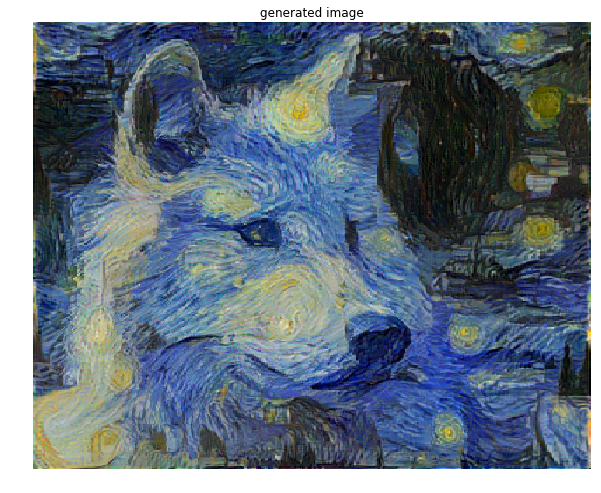

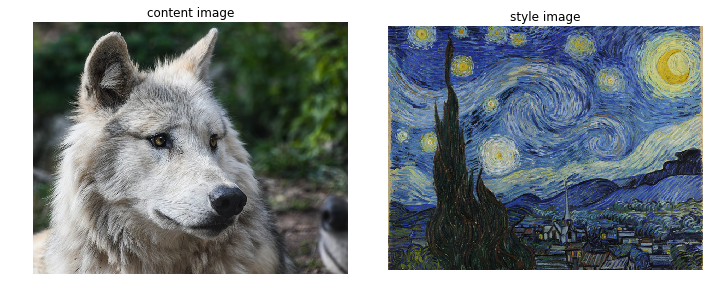

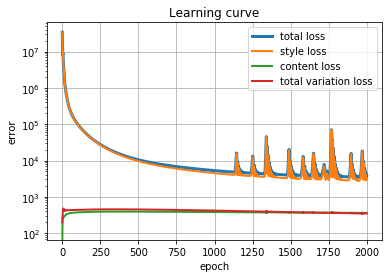

In [14]:
# Generated image.
plt.figure(figsize=(10,10))
plt.imshow(np.asarray(generated_image))
plt.title('generated image')
plt.axis('off')
plt.show()

# Original content/style image.
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,8))
ax[0].set_title('content image')
ax[0].imshow(np.asarray(img_content_orig))
ax[0].axis('off')
ax[1].set_title('style image')
ax[1].imshow(np.asarray(img_style_orig))
ax[1].axis('off')
plt.tight_layout()
plt.show()

# Learning curve.
plt.plot(learning_curve_total, linewidth=3, label='total loss')
plt.plot(learning_curve_style, linewidth=2, label='style loss')
plt.plot(learning_curve_content, linewidth=2, label='content loss')
plt.plot(learning_curve_tv, linewidth=2, label='total variation loss')
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

(Style image: *"The Starry Night"*, Vincent van Gogh, 1889. Content image: Photo by [Pixabay](https://pixabay.com/).)

## Analysis
The figure below shows how the style and content of images are represented in each convolution layer of VGG. The first row shows the original style and content images, and from second to last row, we present the images reconstructed from only feature responses in each layer (Reconstruction methods which Gatys et al. used are based on Mahendran et al. 2014[6]. In brief, the gradient descent is executed to optimize the content loss of the target layer for content reconstruction. Please see Appendix below if you want to know more detail.).  

With respect to the style representation (left), texture patterns are getting more global in higer layers. The right column shows that content information is preserved even in higher layers, although detailed pixel information is lost.

![](./fig/fig1a.png)

Next, we compared style/content representation of the generated image to the input style/content images in the figure below. The images were reconstructed from the layers used to compute the loss function(style: conv1_1-conv5_1, content: conv5_2). We found that the style representation of the generated image are almost the same as the style image. In terms of the content representation, we can see the content (wolf) in both of the reconstructed images, though overall appearances are slightly different.

![](./fig/fig2.png)

## Some other results

![](./fig/fig3.png)

(A: *"Portrait of Mademoiselle Irene Cahen d’Anvers"* by Pierre-Auguste Renoir, 1880. B: *"The Great Wave off Kanagawa"* by Katsushika Hokusai, 1847. C: *"Blue Painting"* by Wassily Kandinsky, 1924. D-G: Images by [Pixabay](https://pixabay.com/).)

## References
[1] Gatys, Leon A., Alexander S. Ecker, and Matthias Bethge. "Image style transfer using convolutional neural networks." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). 2016.  
http://ieeexplore.ieee.org/document/7780634/  
[2] Gatys, Leon A., Alexander S. Ecker, and Matthias Bethge. "A Neural Algorithm of Artistic Style." arXiv preprint arXiv:1508.06576. 2015.  
http://arxiv.org/abs/1508.06576  
[3] Simonyan, K. and Zisserman, A. "Very Deep Convolutional Networks for Large-Scale Image Recognition", arXiv:1409.1556  
http://www.robots.ox.ac.uk/~vgg/research/very_deep/  
[4] Min Lin, Qiang Chen, Shuicheng Yan. "Network In Network." arXiv:1312.4400  
https://arxiv.org/abs/1312.4400  
[5] Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition (CVPR). 2015.  
http://ieeexplore.ieee.org/document/7298594/  
[6] Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep image representations by inverting them." arXiv:1412.0035  
https://arxiv.org/abs/1412.0035  

## Appendix: Style/Content Reconstruction
In this section, we introduce how to reconstruct images from CNN feature maps. The method is explained by Gatys et al., and it is based on Mahendran et al. 2014.[6].   

For content reconstruction, we perform gradient descent on a white noise image to find another image that matches the feature responses of the original image.
That is, the loss function is

\begin{equation*}
 \mathcal{L}_{content}(\vec{p},\vec{x},l)=\frac{1}{2} \sum_{i,j}(F^l_{ij}-P^l_{ij})^2.
\end{equation*}

Note that we don't use the style loss.  

Style reconstruction is also executed via gradient descent. The loss function includes only the style loss.

\begin{equation*}
 \mathcal{L}_{style}(\vec{a},\vec{x},l)=\frac{1}{4N_l^2 M_l^2} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2
\end{equation*}

If you want to reconstruct an image from multiple layers, the loss function is weighted sum of the above $\mathcal{L}_{style}$ over target layers.  

Then, we can reuse the code for style transfer algorithm above.  
The changes from the code are shown below.

### Code for Content Reconstruction (excerpt)

* Loss function settings

```python
# Layers used to calculate the content loss and their weights.
layers_content = ['conv5_2',] ##CHANGE## Select the target layers
w_content = rm.Node(np.array([2**i for i in range(len(layers_content))]))
w_content = w_content / rm.sum(w_content)
```

* Optimization Settings

```python
# Initialization method of the generated image. (content image/random image)
# init_mode = "content"
init_mode = "rand" ##CHANGE## Init by random image.
```

* Execute optimization and generate the image

```python
for i in range(epoch):
    f_gen = model(img_gen)

    l = 0. 
    # Style loss. ##CHANGE## Use only content loss
    #for (layer,w) in zip(layers_style, w_style):
    #    _, channels, height, width = f_gen[layer].shape
    #    gram_gen = gram_mat(f_gen[layer])
    #    l += w * rm.mean_squared_error(gram_gen, f_style[layer])\
    #        / (2. * (channels*height*width)**2)
    l1 = l.as_ndarray()
    # Content loss.
    for (layer,w) in zip(layers_content, w_content):
        l += lam * w * rm.mean_squared_error(f_gen[layer], f_content[layer])
    l2 = l.as_ndarray() - l1
        
    grad = l.grad()
    grad.update(optimizer)
```

### Code for Style Reconstruction (excerpt)

* Loss function settings

```python
# Layers used to calculate the style loss and their weights.
layers_style = ['conv1_1',] ##CHANGE## Select the target layers
w_style = [1./len(layers_style)] * len(layers_style)
```

* Optimization Settings

```python
# Initialization method of the generated image. (content image/random image)
# init_mode = "content"
init_mode = "rand" ##CHANGE## Init by random image.
```

* Execute optimization and generate the image

```python
for i in range(epoch):
    f_gen = model(img_gen)

    l = 0. 
    # Style loss.
    for (layer,w) in zip(layers_style, w_style):
        _, channels, height, width = f_gen[layer].shape
        gram_gen = gram_mat(f_gen[layer])
        l += w * rm.mean_squared_error(gram_gen, f_style[layer])\
            / (2. * (channels*height*width)**2)
    l1 = l.as_ndarray()
    # Content loss. ##CHANGE## Use only style loss
    #for (layer,w) in zip(layers_content, w_content):
    #    l += lam * w * rm.mean_squared_error(f_gen[layer], f_content[layer])
    l2 = l.as_ndarray() - l1
        
    grad = l.grad()
    grad.update(optimizer)
```